In [1]:
import argparse
import pandas as pd
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt


def question_bank(question):
    if question[:3] == 'sim':
        return '-'
    elif question[:3] == 'nat':
        return question[4]
    return 'Error'


def load_results_df(path_saves, path_listener_info, hidden_ref_min):
    df_results = pd.DataFrame()
    df_info = load_listener_info(path_listener_info)
    

    # read all csv results files and create dataframe
    for filename in os.listdir(path_saves):
        if filename.endswith(".csv") and filename[3] == '-':
            path_file = path_saves / filename
            
            df_file = pd.read_csv(path_file)
            df_file = df_file.melt(id_vars=['file_keys'])
            
            df_results = pd.concat([df_results, df_file], ignore_index=True)
            

    # rename columns and unpivot to have each row with a single question answer
    df_results.rename(columns={'variable':'question'}, inplace=True)

    # add info about question. Model, and what question bank it came from, eg. t=tricky, a=alexia (only for nat)
    df_results['question_type'] = df_results['question'].str[:3]
    df_results['model'] = df_results.question.str[-3:]
    is_nat = df_results['question_type'] == 'nat'
    df_results['question_bank'] = df_results.question.apply(question_bank)
    df_results['ref_above_min'] = df_results['value'].apply(lambda x: True if x > hidden_ref_min else False)
    df_results = df_results.merge(df_info, on='file_keys', how='left')
    return df_results


def load_listener_info(path_info):
    df_info = pd.read_csv(path_info)
    return df_info
    


def get_passed(df_results, question_type, avg_ref_min, is_headphones=False,
                       is_quiet_or_headphones=False, english_min=0.25, is_quiet=False):
    # Return a list of unique ids (file_keys) that scored the natural reference high enough consistently
    
    df_results_nat_ref = df_results[(df_results['question_type'] == question_type) * (df_results['model']=='ref')]
    avg_ref = df_results_nat_ref.groupby('file_keys')['ref_above_min'].mean()  # ref_above_min is 1 or 0, so mean is pct above min

    nat_passed = avg_ref[avg_ref > avg_ref_min].index
    print(f'{question_type} ref_min: {len(nat_passed)}')
    
    if is_headphones:
        nat_headphones = df_results[(df_results.headphones == 1) * (df_results['question_type'] == question_type)].file_keys
        nat_passed = nat_passed[nat_passed.isin(nat_headphones)]
        print(f'headphones: {len(nat_headphones.unique())}')
    if is_quiet:
        nat_quiet = df_results[(df_results.quiet == 1) * (df_results['question_type'] == question_type)].file_keys
        nat_passed = nat_passed[nat_passed.isin(nat_quiet)]
        print(f'quiet: {len(nat_quiet.unique())}')
    if is_quiet_or_headphones:
        nat_quiet_filter = (df_results.quiet == 1) * (df_results['question_type'] == question_type)
        nat_headphones_filter = (df_results.headphones == 1) * (df_results['question_type'] == question_type)
        nat_quiet_or_headphones_filter = (nat_quiet_filter + nat_headphones_filter) > 0
        nat_quiet_or_headphones = df_results[nat_quiet_or_headphones_filter].file_keys
        # nat_quiet_or_headphones = df_results[(df_results.quiet == 1 | df_results.headphones == 1) * (df_results['question_type'] == question_type)].file_keys
        nat_passed = nat_passed[nat_passed.isin(nat_quiet_or_headphones)]
        print(f'quiet or headphones: {len(nat_quiet_or_headphones.unique())}')
    
    nat_english_min = df_results[(df_results['question_type']==question_type) * (df_results['english']>english_min)].file_keys
    nat_english_min = nat_english_min.unique()
    print(f'english_min: {len(nat_english_min)}')
    nat_passed = nat_passed[nat_passed.isin(nat_english_min)]
    
    nat_failed = df_results[(~df_results['file_keys'].isin(nat_passed)) * (df_results['question_type']==question_type)].name
    print(f'{question_type} failed:\n{nat_failed.unique()}')
    
    return nat_passed


def get_nat_processed_results(df_results, avg_nat_ref_min, is_headphones=False,
                              is_quiet=False, is_quiet_or_headphones=False,
                              english_min=0.25, question_bank_select=None):
    # get list of ids that passed
    nat_passed = get_passed(df_results, 'nat', avg_nat_ref_min, is_headphones=is_headphones,
                                    is_quiet=is_quiet, is_quiet_or_headphones=is_quiet_or_headphones, english_min=english_min)
    print(f'{len(nat_passed)} participants passed naturalness')
    # given results and ids of who passed, return a dictionary of scores for each model
    results_nat = {'ref': None, 'mel': None, 'v08': None, 'v09': None, 'v10': None}
    nat_models = ['ref', 'mel', 'v08', 'v09', 'v10']

    if question_bank_select == None:
        for model in nat_models:
            results_nat[model] = np.array(df_results[(df_results['question_type'] == 'nat') *
                                                 (df_results['model'] == model) *
                                                 (df_results['file_keys'].isin(nat_passed))
                                                 ].value.tolist())
    else:
        for model in nat_models:
            results_nat[model] = np.array(df_results[(df_results['question_type'] == 'nat') *
                                                    (df_results['model'] == model) *
                                                    (df_results['file_keys'].isin(nat_passed)) *
                                                    (df_results['question_bank']==question_bank_select)
                                                    ].value.tolist())
    
    return results_nat  # dictionary of results


def get_sim_processed_results(df_results, avg_sim_ref_min, is_headphones=False,
                              is_quiet=False, is_quiet_or_headphones=False,
                              english_min=0.25):
    # get list of ids that passed
    sim_passed = get_passed(df_results, 'sim', avg_sim_ref_min, is_headphones=is_headphones,
                                    is_quiet=is_quiet, is_quiet_or_headphones=is_quiet_or_headphones, english_min=english_min)
    print(f'{len(sim_passed)} participants passed similarity')
    results_sim = {'ref': None, 'mel': None, 'v09': None}
    sim_models = ['ref', 'mel', 'v09']

    for model in sim_models:
        results_sim[model] = np.array(df_results[(df_results['question_type'] == 'sim') *
                                                 (df_results['model'] == model) *
                                                 (df_results['file_keys'].isin(sim_passed))
                                                ].value.tolist())
    return results_sim  #dictionary of results


def bootstrap_results(results_type, nb_bootstrap=5000):
    # given a dictionary of results and the number of times to iterate bootstrap, calculate the mean and confidence intervals
    results_mean = {}

    # get the list of results for a specific model, eg. mel
    for model in results_type:
        results = results_type[model]
        N = len(results)
        results_mean[model] = {}
        # calculate the given mean from the original sample
        results_mean[model]['mean'] = results.mean()    
        
        # now repeat bootstrap and calculate distribution of means
        mean_list = []
        for n in range(int(nb_bootstrap)):
            random_sample = np.random.choice(results, size=N, replace=True)
            mean_list.append(random_sample.mean())
        mean_list.sort()
        
        # get the 95% confidence intervals
        lower_index = int(0.025 * nb_bootstrap)
        upper_index = int(0.975 * nb_bootstrap)
        results_mean[model]['lower'] = mean_list[lower_index]
        results_mean[model]['upper'] = mean_list[upper_index]
        
    return results_mean  # dictionary of mean, and CI for each model


def bootstrap_dependent_results(results_type, nb_bootstrap=5000):
    # given a dictionary of results and the number of times to iterate bootstrap, calculate the mean and confidence intervals
    results_mean = {}
    means_list_models = [[] for i in range(len(results_type))]
    N = len(results_type[list(results_type.keys())[0]])
    
    for n in range(nb_bootstrap):
        random_sample_index = np.random.choice(range(N), size=N, replace=True)
        for i, model in enumerate(results_type):
            results = results_type[model]
            random_sample = results[random_sample_index]
            means_list_models[i].append(random_sample.mean())
    
    for model in results_type:
        results_mean[model] = {}
        results_mean[model]['mean'] = results_type[model].mean()
        
        means_list = means_list_models[i]
        means_list.sort()
        
        # get the 95% confidence intervals
        lower_index = int(0.025 * nb_bootstrap)
        upper_index = int(0.975 * nb_bootstrap)
        results_mean[model]['lower'] = means_list[lower_index]
        results_mean[model]['upper'] = means_list[upper_index]
        
    return results_mean


def print_results_mean(results_mean, question_type):
    print(f'*****************')
    print(f'{question_type:17}')
    print(f'*****************')
    for model in results_mean:
        mean = results_mean[model]['mean']
        lower = results_mean[model]['lower']
        upper = results_mean[model]['upper']
        print(f'{model}:\n    mean: {mean:0.3f}\n    CI: [{lower:0.3f}, {upper:0.3f}]\n')


def hist_with_CI(ax, results_mean, label_dict, title):
    # Sample data
    means = []
    lower_bounds = []
    upper_bounds = []
    labels=[]
    for model in results_mean:
        means.append(results_mean[model]['mean'])
        lower_bounds.append(results_mean[model]['lower'])
        upper_bounds.append(results_mean[model]['upper'])
        labels.append(label_dict[model])

    # Create a figure and axis

    bar_width = 0.35

    # Plot means with error bars (confidence intervals)
    ax.bar(labels, means, bar_width, label='Mean')
    ax.errorbar(labels, means, yerr=[means[i] - lower_bounds[i] for i in range(len(means))], fmt='.', label='95% confidence', color='black')


    # Add a legend
    ax.legend()

    # Add labels and title
    # ax.set_xlabel('Groups')
    ax.set_ylabel('Values')
    ax.set_title(title)


def boxplot_with_CI(ax, results, nb_bootstrap, title, label_dict):
    data = []
    labels = []
    for key in results:
        data.append(results[key])
        labels.append(label_dict[key])

    ax.boxplot(data, labels=labels, notch=True, bootstrap=nb_bootstrap)
    ax.set_ylabel('Values')
    ax.set_title(title)

In [2]:
hidden_ref_min=0.5
pct_natural_ref_passed=0.6
pct_sim_ref_passed=0.6
ratings_path='./../saves/ratings'
listener_info_path='./../saves/ratings/listener_info.csv'
is_headphones=False
is_quiet=False
is_quiet_or_headphones=True
english_min=0.5
question_bank_select = None    # either: 'a' 't' None

label_dict = {'ref':'Reference', 'mel':'mel', 'v08':'w2v_pt_L12', 'v09':'w2v_ft_L09', 'v10':'w2v_pt_L09'}

In [3]:
nb_bootstrap=5000
path_saves = Path(ratings_path)
path_listener_info = Path(listener_info_path)
hidden_ref_min = hidden_ref_min  # minimum score for ref for it to be classed as success
avg_nat_ref_min = pct_natural_ref_passed  # average success score for person's results to be used
avg_sim_ref_min = pct_sim_ref_passed  # average success score for person's results to be used

df_results = load_results_df(path_saves, path_listener_info, hidden_ref_min)
results_nat = get_nat_processed_results(df_results, avg_nat_ref_min, is_headphones=is_headphones,
                                        is_quiet=is_quiet, is_quiet_or_headphones=is_quiet_or_headphones,
                                        english_min=english_min, question_bank_select=question_bank_select)
results_nat_alexia = get_nat_processed_results(df_results, avg_nat_ref_min, is_headphones=is_headphones,
                                        is_quiet=is_quiet, is_quiet_or_headphones=is_quiet_or_headphones,
                                        english_min=english_min, question_bank_select='a')
results_nat_test = get_nat_processed_results(df_results, avg_nat_ref_min, is_headphones=is_headphones,
                                        is_quiet=is_quiet, is_quiet_or_headphones=is_quiet_or_headphones,
                                        english_min=english_min, question_bank_select='t')
results_sim = get_sim_processed_results(df_results, avg_sim_ref_min, is_headphones=is_headphones,
                                        is_quiet=is_quiet, is_quiet_or_headphones=is_quiet_or_headphones, english_min=english_min)
nat_results_mean = bootstrap_results(results_nat, nb_bootstrap=nb_bootstrap)
nat_results_mean_alexia = bootstrap_results(results_nat_alexia, nb_bootstrap=nb_bootstrap)
# nat_results_mean_test = bootstrap_results(results_nat_test, nb_bootstrap=nb_bootstrap)
sim_results_mean = bootstrap_results(results_sim, nb_bootstrap=nb_bootstrap)

print_results_mean(nat_results_mean, 'Naturalness')
print_results_mean(sim_results_mean, 'Similarity')

nat ref_min: 41
quiet or headphones: 50
english_min: 50
nat failed:
['Jake Egbers' 'Franck Barga' 'Hanson ' 'Emily Delve' 'George'
 'Mike Jones' 'Stephen Lay' 'Tom Emberson' 'Ross']
41 participants passed naturalness
nat ref_min: 41
quiet or headphones: 50
english_min: 50
nat failed:
['Jake Egbers' 'Franck Barga' 'Hanson ' 'Emily Delve' 'George'
 'Mike Jones' 'Stephen Lay' 'Tom Emberson' 'Ross']
41 participants passed naturalness
nat ref_min: 41
quiet or headphones: 50
english_min: 50
nat failed:
['Jake Egbers' 'Franck Barga' 'Hanson ' 'Emily Delve' 'George'
 'Mike Jones' 'Stephen Lay' 'Tom Emberson' 'Ross']
41 participants passed naturalness
sim ref_min: 26
quiet or headphones: 47
english_min: 47
sim failed:
['Franck Barga' 'Hanson ' 'James grant ' 'Monica Davidson' 'Alex'
 'Chloé Francois' 'Jacob Pope' 'Steve Nash' 'Emily Delve' 'Tony Clarke'
 'Tertia Nash' 'John Keast' 'Jake Egbers' 'Peter Greene' 'Paridhi Rustogi'
 'Tracy Frankpitt' 'Stephen Lay' 'Patrick' 'George' 'Denis Mitchell'

/home/fred/miniconda3/envs/deepzen-v1/lib/python3.10/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/tmp/ipykernel_332/123508472.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


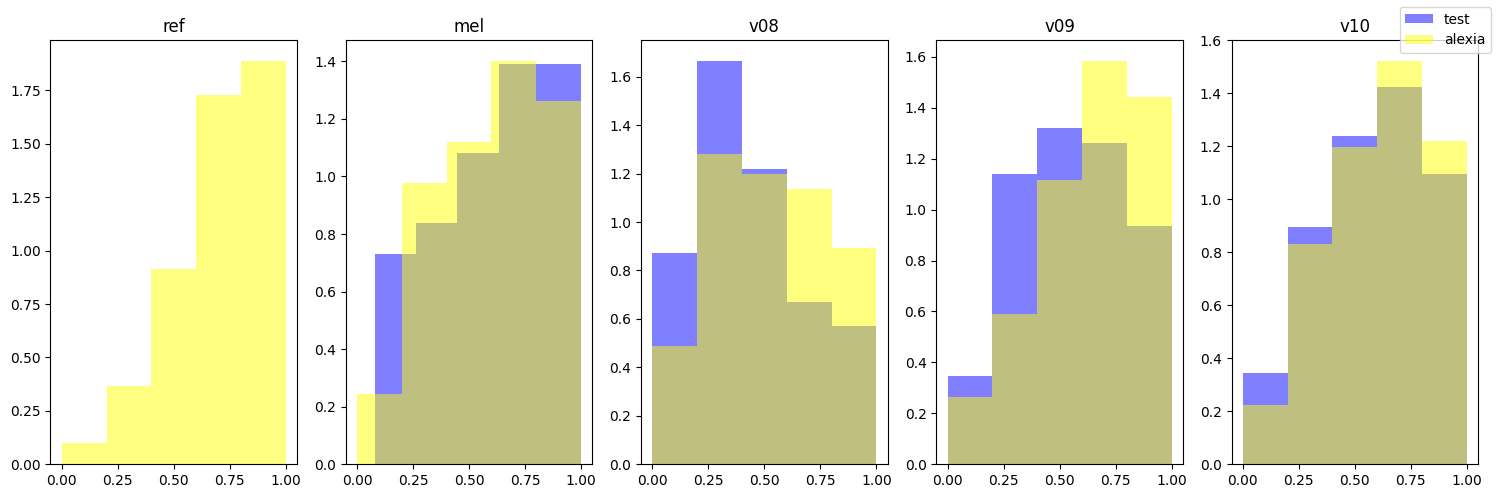

In [4]:
alpha = 0.5
colours = ['red', 'blue', 'yellow']

fig, axs = plt.subplots(1, 5, figsize=(15,5))
axs_flatten = axs.flatten()

for i, model in enumerate(results_nat):
    ax = axs_flatten[i]
    
    #ax.hist(results_nat[model], bins=5, alpha=alpha, color=colours[0], label='all', density=True)
    ax.hist(results_nat_test[model], bins=5, alpha=alpha, color=colours[1], label='test', density=True)
    ax.hist(results_nat_alexia[model], bins=5, alpha=alpha, color=colours[2], label='alexia', density=True)
    ax.set_title(model)
    if i==0:
        fig.legend()
fig.tight_layout()
fig.show()

/tmp/ipykernel_332/508313180.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


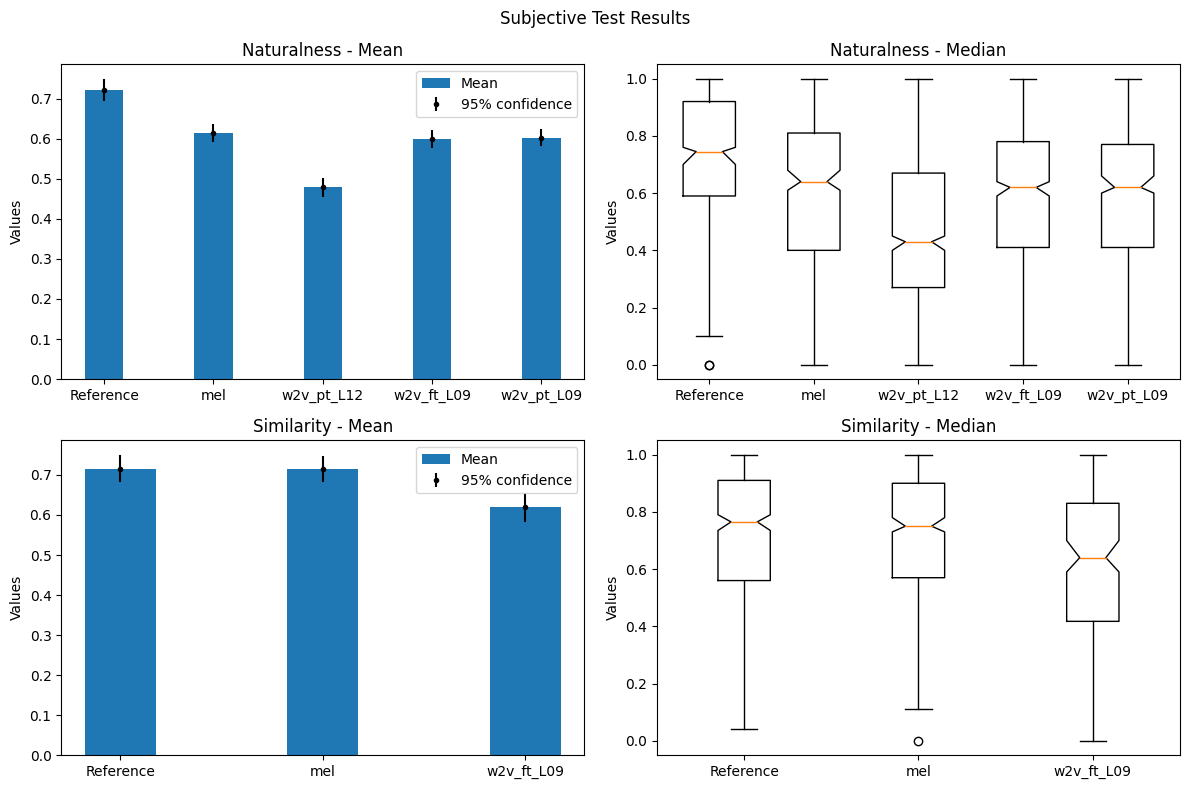

In [5]:
fig, axs = plt.subplots(2,2, figsize=(12,8))
axs_flatten = axs.flatten()

hist_with_CI(axs_flatten[0], nat_results_mean, label_dict, 'Naturalness - Mean')
boxplot_with_CI(axs_flatten[1], results_nat, nb_bootstrap, 'Naturalness - Median', label_dict)
hist_with_CI(axs_flatten[2], sim_results_mean, label_dict, 'Similarity - Mean')
boxplot_with_CI(axs_flatten[3], results_sim, nb_bootstrap, 'Similarity - Median', label_dict)

fig.suptitle('Subjective Test Results')
fig.tight_layout()
fig.show()